# Instalar YOLOV5

In [1]:
!git clone https://github.com/ArtBreguez/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9469, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9469 (delta 2), reused 2 (delta 0), pack-reused 9460
Receiving objects: 100% (9469/9469), 11.70 MiB | 10.24 MiB/s, done.
Resolving deltas: 100% (6327/6327), done.
/tmp/tcc_alpd/yolov5/yolov5


In [2]:
!pip install -r requirements.txt

In [3]:
import utils
display = utils.notebook_init()

YOLOv5 🚀 254aef3 Python-3.8.18 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2080, 7959MiB)


Setup complete ✅ (6 CPUs, 31.3 GB RAM, 136.1/914.8 GB disk)


# Preparar Dataset

In [4]:
import os
import shutil
import random

In [5]:
IMAGE_PATH = "/tmp/tcc_alpd/archive/images"
ANNOTATIONS_PATH = "/tmp/tcc_alpd/archive/annotations"
#DATASET_PATH = "Dataset/"
TRAIN_LABELS_PATH = "Dataset/train/labels"
VAL_LABELS_PATH = "Dataset/val/labels"
TRAIN_IMAGES_PATH = DATASET_PATH+"Dataset/train/images"
VAL_IMAGES_PATH = DATASET_PATH+"Dataset/val/images"

In [6]:
def split_dataset(source_dir, train_dir, val_dir, val_percentage=0.1):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(train_dir+"/labels", exist_ok=True)
    os.makedirs(val_dir+"/labels", exist_ok=True)
    os.makedirs(train_dir+"/images", exist_ok=True)
    os.makedirs(val_dir+"/images", exist_ok=True)

    files = os.listdir(source_dir)
    random.shuffle(files)

    num_val_files = int(len(files) * val_percentage)

    for i, file in enumerate(files):
        source_file = os.path.join(source_dir, file)
        if i < num_val_files:
            shutil.copy(source_file, os.path.join(val_dir, file))
        else:
            shutil.copy(source_file, os.path.join(train_dir, file))

In [7]:
split_dataset(IMAGE_PATH, DATASET_PATH+"train", DATASET_PATH+"val")

# Converter anotações COCO para YOLOV5 labels


In [8]:
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse

In [9]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def save_file(img_jpg_file_name, size, img_box, labels_path):
    classes = ['license']
    save_file_name = DATASET_PATH + labels_path + '/' + img_jpg_file_name + '.txt'
    file_path = open(save_file_name, "a+")
    for box in img_box:
        cls_num = 0
        new_box = cord_converter(size, box[1:])

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()

def get_xml_data(file_path, img_xml_file, labels_path):
    img_path = file_path + '/' + img_xml_file + '.xml'
    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    save_file(img_xml_file, [img_w, img_h], img_box, labels_path)

In [10]:
def process_files(annotations_path, train_val_dir, labels_path, images_path):
    xml_files = [f for f in os.listdir(annotations_path) if f.endswith('.xml')]
    
    files = [f.split('.')[0] for f in os.listdir(train_val_dir) if f.endswith('.png')]
    
    for xml_file in xml_files:
        xml_name = xml_file.split('.')[0]
        if xml_name in files:
            get_xml_data(annotations_path, xml_name, labels_path)
            src_path = os.path.join(train_val_dir, f"{xml_name}.png")
            print(src_path)
            dest_path = os.path.join(images_path, f"{xml_name}.png")
            shutil.move(src_path, dest_path)


In [11]:
process_files(ANNOTATIONS_PATH, DATASET_PATH+"train", TRAIN_LABELS_PATH, TRAIN_IMAGES_PATH)
process_files(ANNOTATIONS_PATH, DATASET_PATH+"val", VAL_LABELS_PATH, VAL_IMAGES_PATH)

Dataset/train/Cars400.png
Dataset/train/Cars104.png
Dataset/train/Cars224.png
Dataset/train/Cars311.png
Dataset/train/Cars319.png
Dataset/train/Cars73.png
Dataset/train/Cars11.png
Dataset/train/Cars326.png
Dataset/train/Cars304.png
Dataset/train/Cars347.png
Dataset/train/Cars367.png
Dataset/train/Cars186.png
Dataset/train/Cars364.png
Dataset/train/Cars351.png
Dataset/train/Cars228.png
Dataset/train/Cars278.png
Dataset/train/Cars365.png
Dataset/train/Cars129.png
Dataset/train/Cars292.png
Dataset/train/Cars201.png
Dataset/train/Cars226.png
Dataset/train/Cars432.png
Dataset/train/Cars105.png
Dataset/train/Cars397.png
Dataset/train/Cars313.png
Dataset/train/Cars143.png
Dataset/train/Cars47.png
Dataset/train/Cars72.png
Dataset/train/Cars90.png
Dataset/train/Cars272.png
Dataset/train/Cars107.png
Dataset/train/Cars180.png
Dataset/train/Cars6.png
Dataset/train/Cars265.png
Dataset/train/Cars48.png
Dataset/train/Cars283.png
Dataset/train/Cars191.png
Dataset/train/Cars20.png
Dataset/train/Cars163

# YOLOV5 treinamento


In [12]:
!python train.py --img 416 --batch 16 --epochs 50 --data data/alpr.yaml --cfg models/yolov5s.yaml

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/alpr.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ArtBreguez/yolov5 ✅
YOLOv5 🚀 254aef3 Python-3.8.18 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2080, 7959MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015

# Analise de resultados

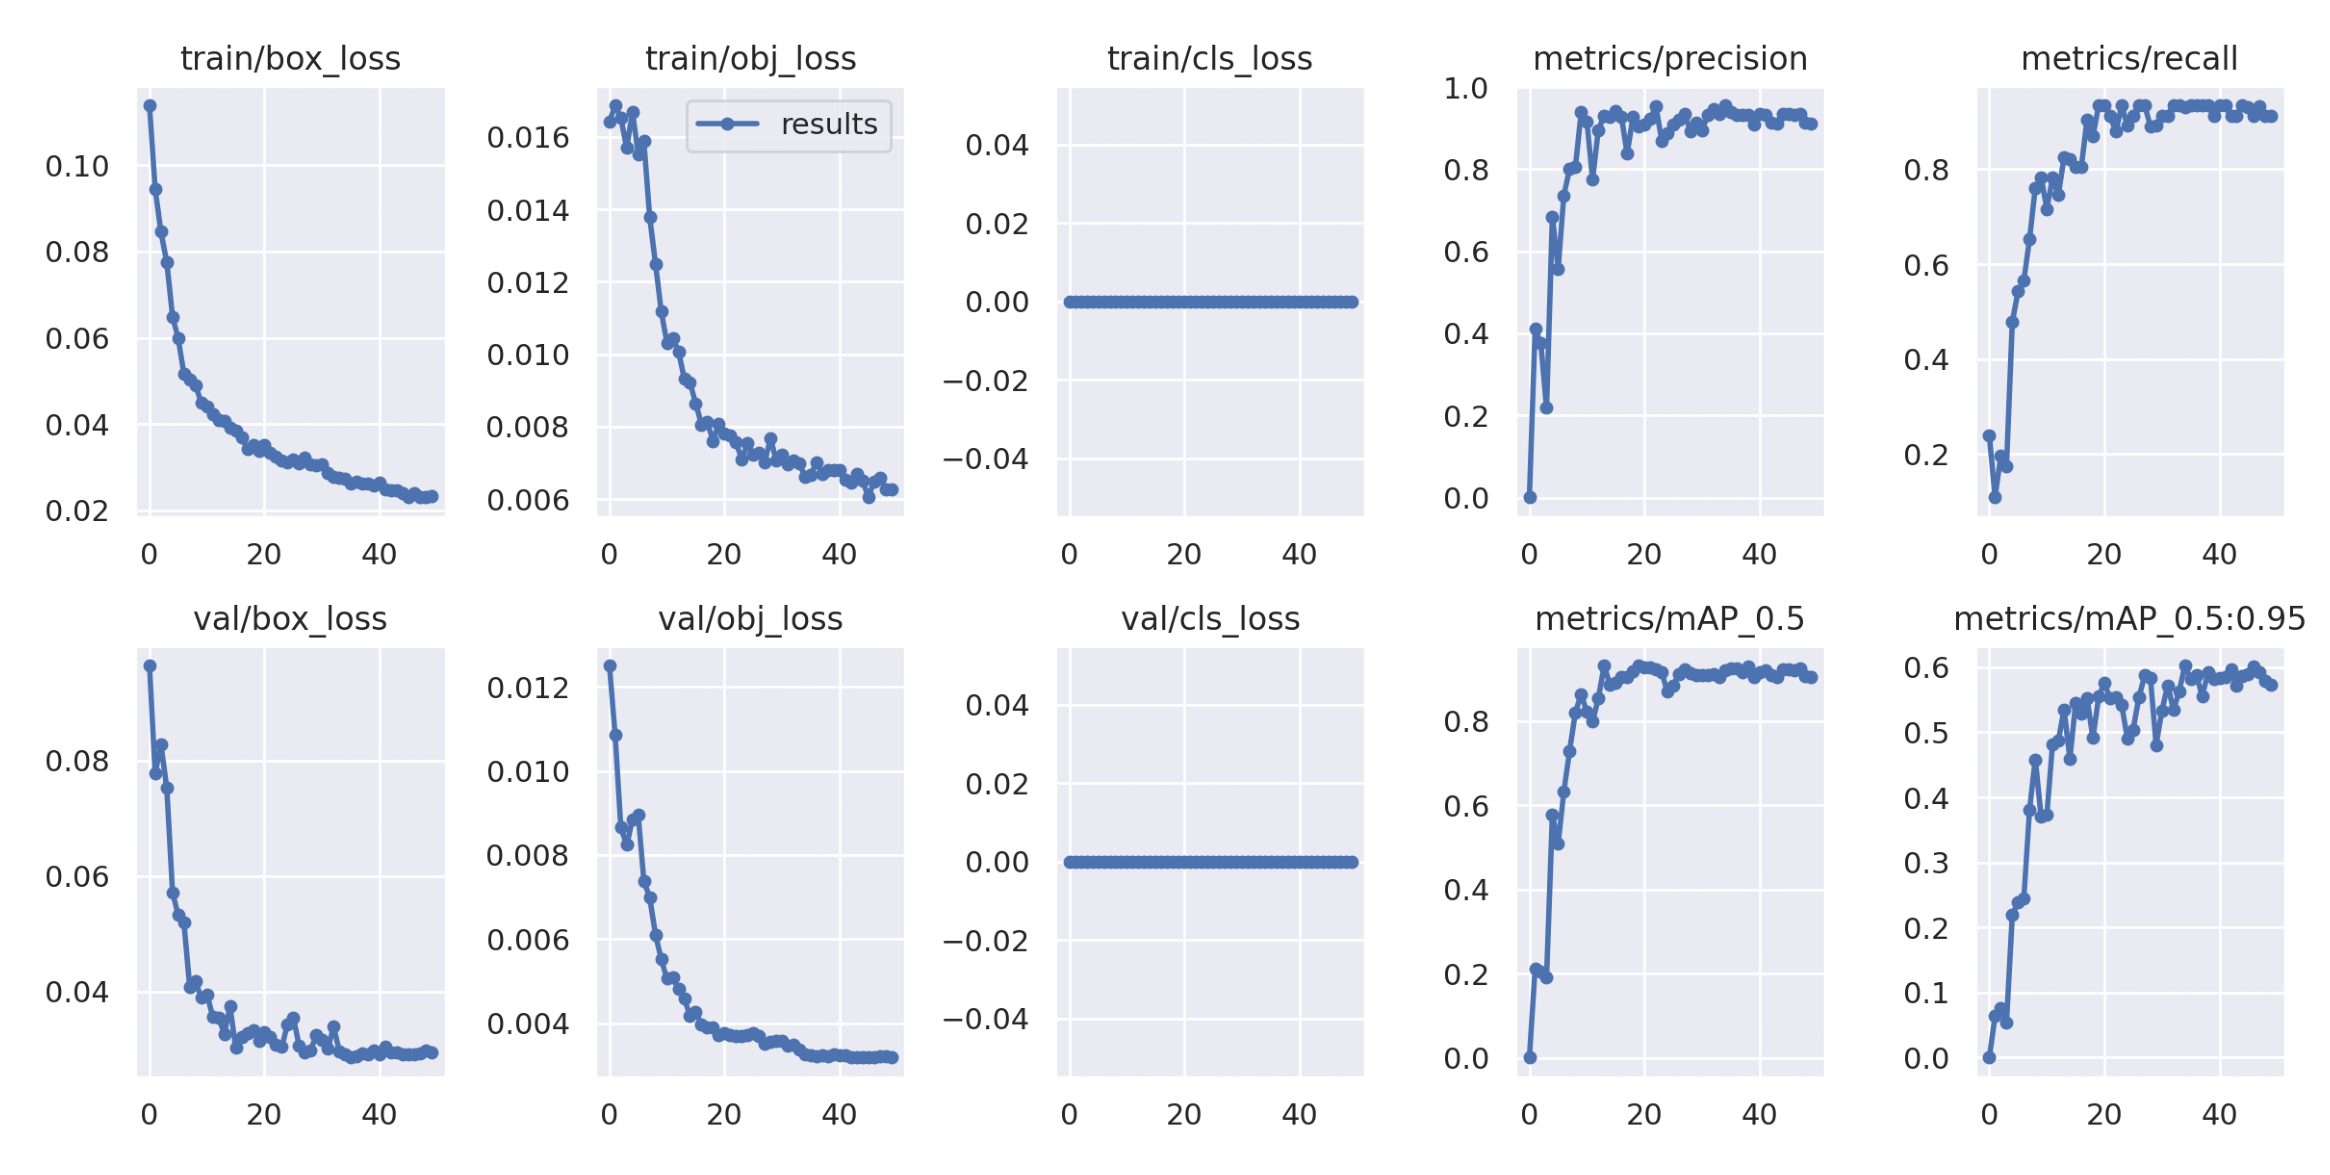

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'))

In [3]:
# validation
!python val.py --weights 'runs/train/exp/weights/best.pt' --img 416 --batch 64 --data data/alpr.yaml --project 'alpr' --name 'validation_on_test_data' --augment

val: data=data/alpr.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=64, imgsz=416, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs_alpr, name=validation_on_test_data, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 254aef3 Python-3.8.18 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2080, 7959MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/tmp/tcc_alpd/yolov5/yolov5/Dataset/val/labels.cache' images and 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         43         46      0.952      0.935       0.94      0.567
Speed: 0.5ms pre-process, 5.7ms inference, 3.6ms NMS per image at shape (64, 3, 416, 416)
Results saved to runs_alpr/validation_on_test_data2


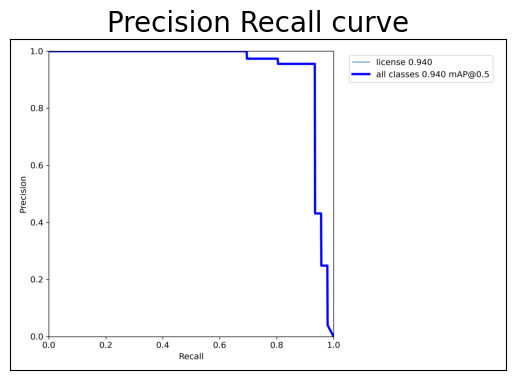

In [7]:
import matplotlib.image as mpimg

plt.plot(figsize=(20,20))
plt.title('Precision Recall curve', fontsize=20)
plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
plt.imshow(mpimg.imread('runs_alpr/validation_on_test_data2/PR_curve.png'))

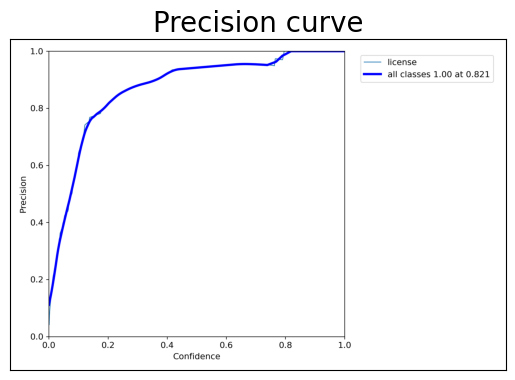

In [9]:
plt.plot(figsize=(20,20))
plt.title('Precision curve', fontsize=20)
plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
plt.imshow(mpimg.imread('runs_alpr/validation_on_test_data2/P_curve.png'))

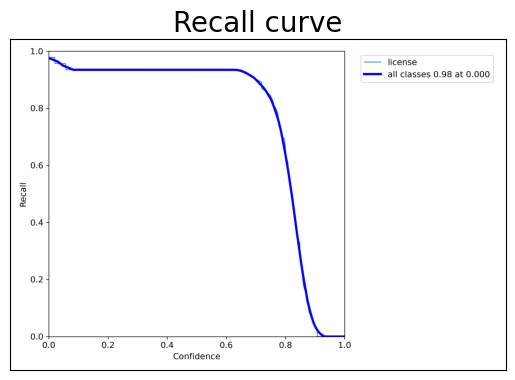

In [11]:
plt.plot(figsize=(20,20))
plt.title('Recall curve', fontsize=20)
plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
plt.imshow(mpimg.imread('runs_alpr/validation_on_test_data2/R_curve.png'))

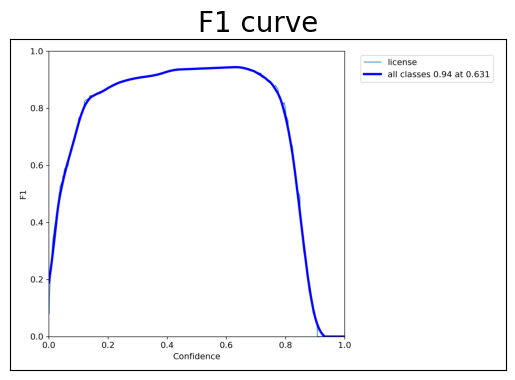

In [13]:
plt.plot(figsize=(20,20))
plt.title('F1 curve', fontsize=20)
plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
plt.imshow(mpimg.imread('runs_alpr/validation_on_test_data2/F1_curve.png'))

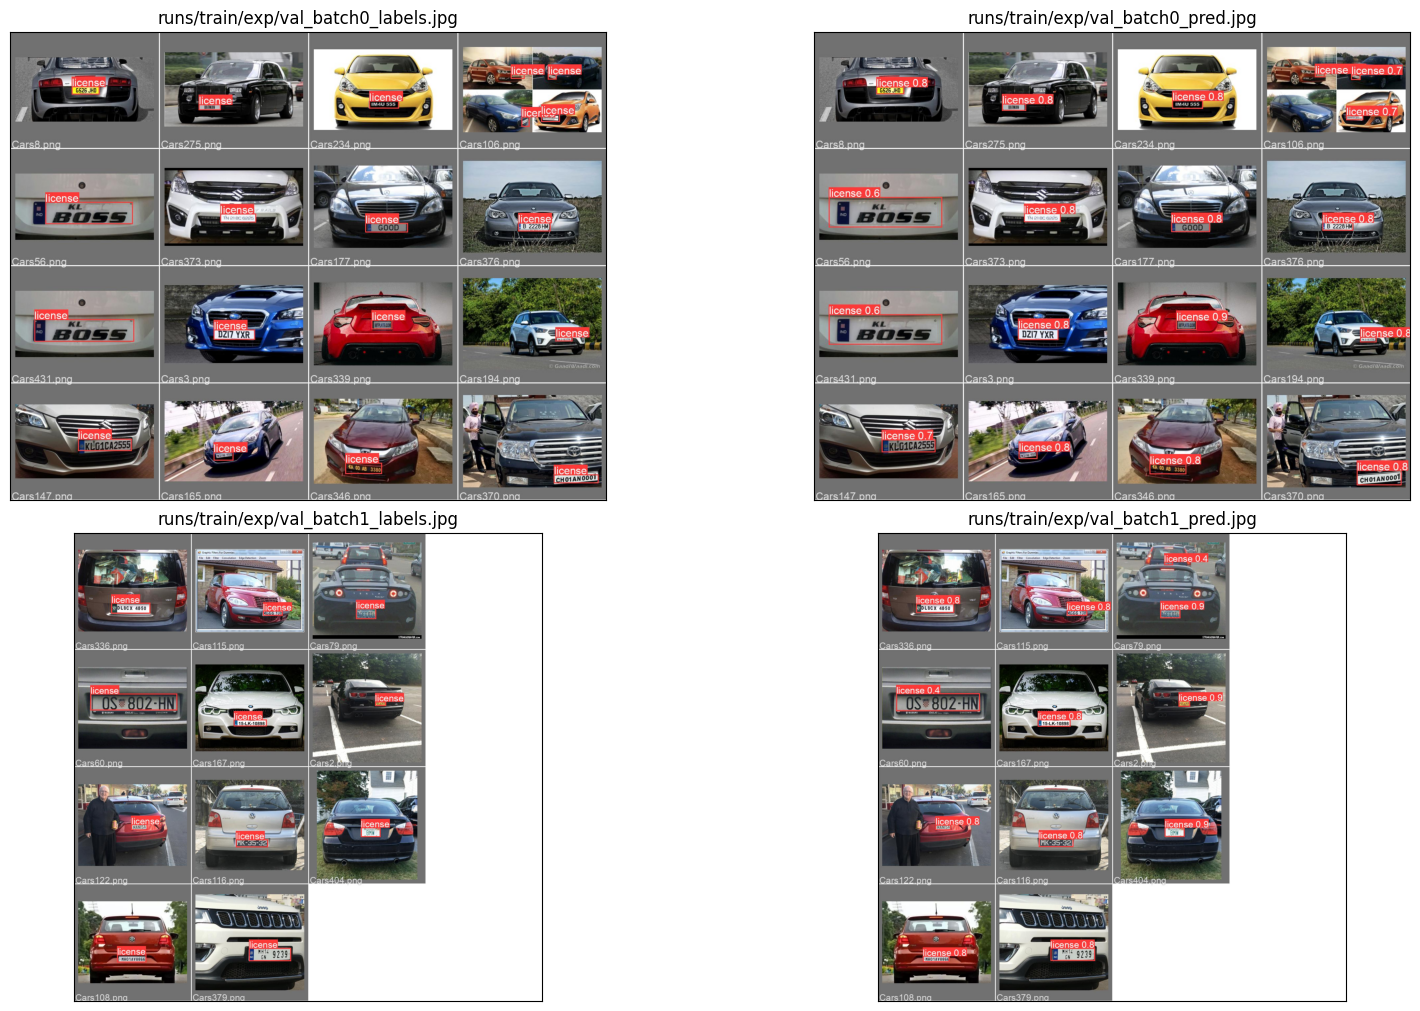

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (2*8,2*5), constrained_layout = True)
for row in range(2):
    ax[row][0].imshow(plt.imread(f'runs/train/exp/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'runs/train/exp/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'runs/train/exp/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'runs/train/exp/val_batch{row}_pred.jpg', fontsize = 12)
plt.show()